## Batch Normalization

Batch Normalization to technika, która została wprowadzona w roku 2015, w publikacji naukowej auotorstwa Sergey loffe i Christian Szegedy. 

Link: https://arxiv.org/pdf/1502.03167.pdf

Zanim zaczniemy wyjaśniać jakie korzyści z niej płyną, pierw wyjaśnijmy odrobinę po co w ogóle normalizujemy dane w Sieci Neuronowe. Jednym z powodów, który już został wspomiany to przede wszystkim uniknięcie operacji na dużych liczbach. Drugim powodem jest natomiast to, że **normalizacja przyśpiesza zbliżanie się do minimum globalnego**.

Istnieje wiele metod na wizualizacje błędu sieci neuronowej. Nie koniecznie musi to być liczba, czasami możemy wygenerować przestrzeń a czasami warto pokazać go jako "poziomica":

![error](http://masters.donntu.org/2006/fvti/gogolenko/diss/img/descent_schema.gif)

Tak więc kiedy nie normalizujemy naszych danych to przestrzeń błędu mogłaby wyglądać przykładowo tak:

![error_space_not_normalized](https://i.imgur.com/JW0gLYY.png =500x)

Jeżeli natomiast znormalizujemy dane (odejmiemy ich średnią i podzielimy przez odchylenie standardowe), wtedy przestrzeń naszego błędu jest wycentrowana:

![error_space_normalized](https://i.imgur.com/Jl1UyRe.png =500x)

Nie ważne jakie wartosci wylosujemy podczas inicializacji wag modelu, **dystans od minimum globalnego powinien być zawsze stały**. Możemy więc stwierdzić, że normalizacja danych to coś co zdecydowanie pomaga. Jeżeli popatrzymy na strukturę każdej sieci neuronowej, to dane są tak naprawde warstwą wejściową do modelu. Jeżeli wyobrazimy sobie 4-warstwową sieć neuronową, to możemy powiedzieć, że warstwa pierwsza jest wejściem do mniejszej 3-warstwowej sieci neuronowej:

![imagine](https://i.imgur.com/6ssLEyC.png =400x)

Stąd pomysł by znormalizować wejście do każdej kolejnej warstwy. I to właśnie robi Batch Normalization. 


### Dlaczego warto stosować Batch Normalization?

- **sieć neuronowa uczy się szybciej** - każda epoka będzie zabierać więcej czasu, ponieważ dodatkowa normalizacja to dodatkowe obliczenia matematyczne, ale z każdą epoką sieć będzie dużo szybciej zbliżać się do minimum globalnego więc mniej epok będzie potrzebnych
- **możemy używać większych wartości parametru learning rate** - zwykle potrzebujemy bardzo małych wartości parametru learning rate by sieć się nauczyła, wszystko dzięki temu, że wartości na neuronach są zawsze normalizowane
- **możemy mniej martwić się o poprawną inicializację wag**
- **możemy używać większej ilości funkcji aktwacji** - niweluje na przykład problem zanikającego gradientu przy użyciu sigmoida i tangensu hyperbolicznego, poprzez regulowanie zakresu wartości na neuronach nie musimy się martwić o "umierające" neurony aktywowane ReLU
- **regularyzuje w małym stopniu** - ale tylko jeżeli używamy małych wartości parametru "batch", im mniejszy parametr "batch" tym na mniejszej ilośći danych dokonujemy normalizacji a tym samym zmieniamy proporcje liczb, jako że dostosowują się one do średniej i odchylenia standardowego wewnątrz batcha, a tym samym wprowadzamy dodatkową losowść do modelu a to sprzyja regularyzacji


### Szczegóły implementacyjne

Zmienia się sposób w jaki aktywujemy nasze warstwy. Każda warstwa dostaje nowe, trenowalne parametry $\gamma$ oraz $\beta$. Do tej pory aktywacja wyglądała następująco:
$$ a_n = f(z_{n})$$
$$ z_n = w^T_{n}a_{n-1} + b_n $$

gdzie:
- $a_n$ to aktywacja na n-tej warstwie
- $z_n$ to liniowa kombinacja na n-tej warstwie
- $f$ to funkcja aktywacji
- $b$ to bias

Teraz zanim przekażemy $z_n$ do funkcji aktywacji (które jest wektorem, to wszystkie neurony na warstwie), musimy podzielić je znormalizować:

$$ z^{norm}_n = \frac{z_n - mean(z_n)}{\sqrt{var(z_n) + \text{very_small_number}}}$$
$$ \hat{z_n} = \gamma z^{norm}_n + \beta$$ 

I dopiero $\hat{z_n}$ używane jest do aktywacji:

$$a_n = f(\hat{z_n})$$

I ponieważ normalizacja spłaszcza wartości na warstwie, to by pozwolić sieci się do tego dostosować, dajemy jej parametry $\gamma$ oraz $\beta$, które może uczyć by sobie z tym problemem poradzić. **$\beta$ tak naprawdę to nasz nowy bias, stad dodawanie $b$ przy obliczaniu $z_n$, kiedy używamy Batch Normalization nie jest już konieczne.**

## Porównanie
#### Importy

In [1]:
# Instalcaja Keras
!pip install -q keras
import keras

# Instalacja biblioteki do rysowania tablic
!pip install -q tabulate
import tabulate

# Ogólne
import os
import numpy as np
import random as rn
from scipy.stats import truncnorm
from IPython.display import HTML, display

# Keras & Tensorflow
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.initializers import (
    Zeros, 
    Ones, 
    RandomUniform, 
    RandomNormal, 
    TruncatedNormal, 
    glorot_uniform
)

# Wizualizacja
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

# Kontrola Losowości - ma na celu przybliżyć rezultaty tego notatnika na każdym komputerze
os.environ['PYTHONHASHSEED'] = '0'
RANDOM_SEED = 3939
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)

tf.set_random_seed(RANDOM_SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)

Using TensorFlow backend.


#### Wczytanie danych

In [0]:
from keras.datasets import mnist

# Wczytanie danych do tablic (60000x28x28), (60000x1), (10000x28x28), (10000x1)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Przygotowanie sieci i danych

In [0]:
def build_and_train_model(X_train, y_train, normalize_data=False, learning_rate=0.01,
                          layers=[256, 128, 64], batch_size=None, epochs=None, 
                          activation=None, initializer=None, use_batch_norm=False):
    # Przygotowanie danych
    X_train_copy = X_train.reshape(60000, 784)
    X_train_copy = X_train_copy.astype('float32')
    
    if normalize_data:
      X_train_copy /= 255    
    
    y_train_copy = keras.utils.to_categorical(y_train, 10)
    
    split_ratio = 0.8
    split_index = int(X_train_copy.shape[0] * split_ratio)

    X_train_input, y_train_input = X_train_copy[:split_index], y_train_copy[:split_index]
    X_val_input, y_val_input = X_train_copy[split_index:], y_train_copy[split_index:]
  
    # Wyciągnięcie wielkości pierwszej warstwy z wektora wartości wejściowych
    input_units = X_train_input[0].shape[0]
    
    # Wyciągnięcie ilości klas z kształtu wektora wartości docelowych
    num_classes = y_train_input[0].shape[0]
    
    # Zadeklarowanie struktury modelu
    model = Sequential()
    
    for i, layer_size in enumerate(layers):
      if i == 0:
        model.add(Dense(layer_size, 
                        activation=activation, 
                        input_shape=(input_units,),
                        use_bias=(not use_batch_norm),
                        kernel_initializer=initializer))

      else:
        model.add(Dense(layer_size, 
                        activation=activation, 
                        use_bias=(not use_batch_norm),
                        kernel_initializer=initializer))
      if use_batch_norm:
        model.add(BatchNormalization())
        
    model.add(Dense(num_classes, 
                    activation="softmax",
                    kernel_initializer=initializer))
    
    # Stworzenie modelu, wybranie funkcji kosztu, optymizera oraz metryki
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), 
                  metrics=["accuracy"])
    
    # Trenowanie sieci
    history = model.fit(X_train_input, y_train_input,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(X_val_input, y_val_input))
    
    # Rezultat
    score = model.evaluate(X_val_input, y_val_input, verbose=0)
    
    return model, history, score

In [0]:
def compare_two_models(X_train, y_train, normalize_data=False, learning_rate=0.01,
                       layers=[256, 128, 64], batch_size=None, epochs=None, 
                       activation=None, initializer=None, title=""):
  model, history, score = build_and_train_model(
    X_train, y_train, normalize_data=normalize_data, learning_rate=learning_rate, layers=layers, 
    batch_size=batch_size, epochs=epochs, activation=activation, initializer=initializer, 
    use_batch_norm=False)

  modeln, historyn, scoren = build_and_train_model(
    X_train, y_train, normalize_data=normalize_data, learning_rate=learning_rate, layers=layers, 
    batch_size=batch_size, epochs=epochs, activation=activation, initializer=initializer, 
    use_batch_norm=True)
  
  test_score, test_accuracy = score
  print("\nModel bez Batch Normalization ")
  print(" - error: {}".format(test_score))
  print(" - acc: {}".format(test_accuracy))

  test_scoren, test_accuracyn = scoren
  print("\nModel z Batch Normalization")
  print(" - error: {}".format(test_scoren))
  print(" - acc: {}".format(test_accuracyn))
  
  f, ax = plt.subplots()
  f.set_size_inches(10, 6)

  ax.plot(history.history["acc"], c="r")
  ax.plot(historyn.history["acc"], c="b")
  ax.set_title(title)
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Epoka")
  ax.legend(["Model bez Batch Normalization", "Model z Batch Normalization"], loc="best");


Model bez Batch Normalization 
 - error: 0.1555229918347656
 - acc: 0.96825

Model z Batch Normalization
 - error: 0.1119177003466175
 - acc: 0.9734166666666667


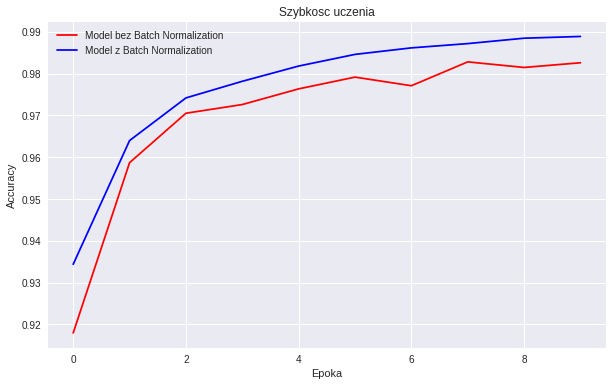

In [5]:
compare_two_models(X_train, y_train, normalize_data=True, learning_rate=0.01, 
    layers=[256, 128, 64], batch_size=128, epochs=10, activation="relu", 
    initializer=glorot_uniform(seed=RANDOM_SEED), title="Szybkosc uczenia")


Model bez Batch Normalization 
 - error: 14.449872362772624
 - acc: 0.1035

Model z Batch Normalization
 - error: 9.670857292175294
 - acc: 0.4


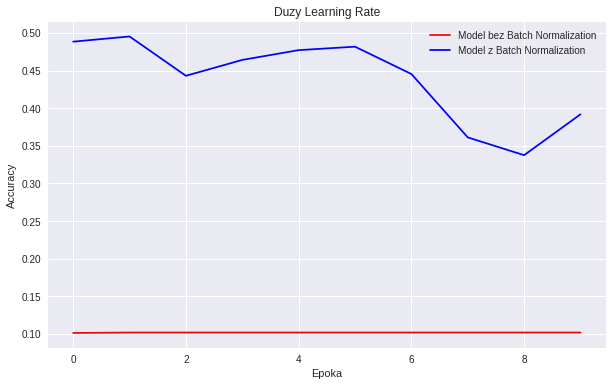

In [6]:
compare_two_models(X_train, y_train, normalize_data=True, learning_rate=1, 
    layers=[256, 128, 64], batch_size=512, epochs=10, activation="relu", 
    initializer=glorot_uniform(seed=RANDOM_SEED), title="Duzy Learning Rate")


Model bez Batch Normalization 
 - error: 13.758137613932291
 - acc: 0.14641666666666667

Model z Batch Normalization
 - error: 0.15147376222277914
 - acc: 0.9631666666666666


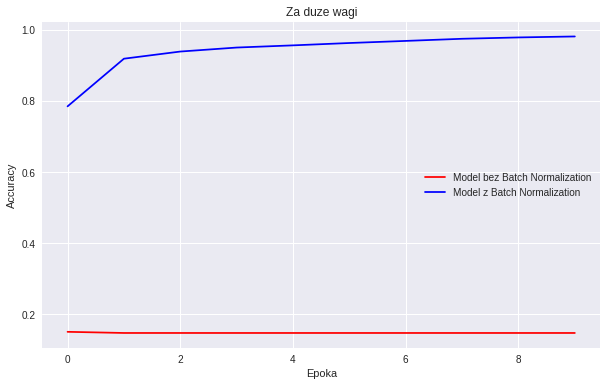

In [7]:
compare_two_models(X_train, y_train, normalize_data=True, learning_rate=0.01, 
    layers=[256, 128, 64], batch_size=128, epochs=10, activation="relu", 
    initializer=RandomUniform(minval=-5, maxval=5, seed=RANDOM_SEED), title="Za duze wagi")


Model bez Batch Normalization 
 - error: 14.40957709757487
 - acc: 0.106

Model z Batch Normalization
 - error: 0.11632362947996201
 - acc: 0.9706666666666667


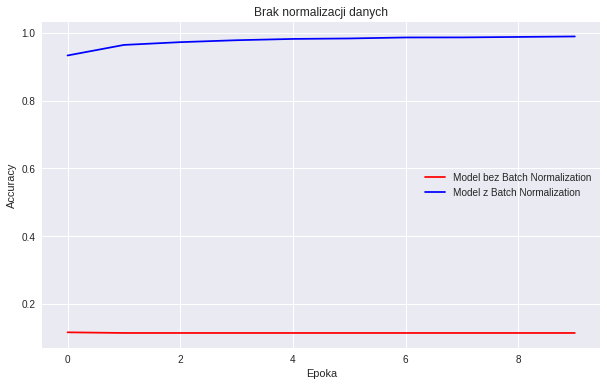

In [9]:
compare_two_models(X_train, y_train, normalize_data=False, learning_rate=0.01, 
    layers=[256, 128, 64], batch_size=128, epochs=10, activation="relu", 
    initializer=glorot_uniform(seed=RANDOM_SEED), title="Brak normalizacji danych")


Model bez Batch Normalization 
 - error: 1.7920219449996948
 - acc: 0.20933333333333334

Model z Batch Normalization
 - error: 0.17693770471960307
 - acc: 0.9565


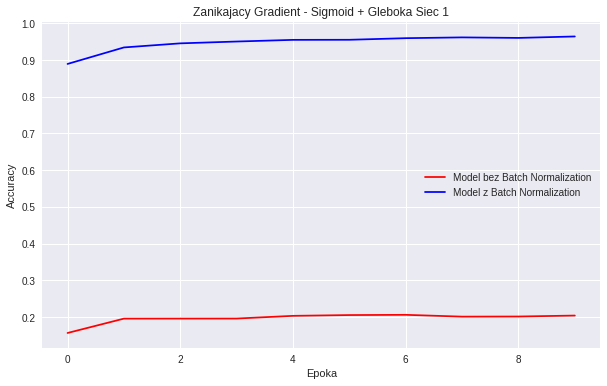

In [10]:
compare_two_models(X_train, y_train, normalize_data=True, learning_rate=0.01, 
    layers=[32, 32, 32, 32, 32, 32, 32, 32, 32], batch_size=128, epochs=10, activation="sigmoid", 
    initializer=glorot_uniform(seed=RANDOM_SEED), title="Zanikajacy Gradient - Sigmoid + Gleboka Siec 1")


Model bez Batch Normalization 
 - error: 2.3030619678497315
 - acc: 0.106

Model z Batch Normalization
 - error: 0.1761725512444973
 - acc: 0.9574166666666667


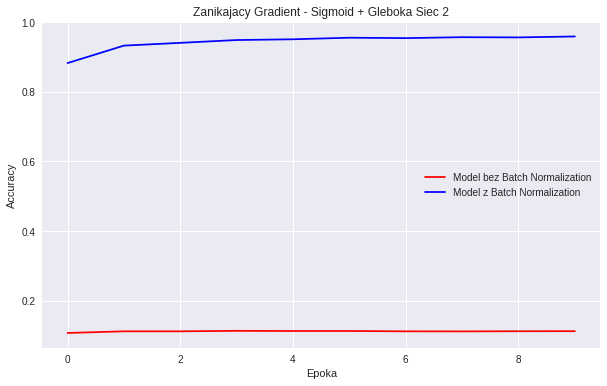

In [11]:
compare_two_models(X_train, y_train, normalize_data=True, learning_rate=0.01, 
    layers=[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32], batch_size=128, epochs=10, activation="sigmoid", 
    initializer=glorot_uniform(seed=RANDOM_SEED), title="Zanikajacy Gradient - Sigmoid + Gleboka Siec 2")